In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import preprocessing
from scipy import stats
from itertools import combinations

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../../data/clf-ab-rows.json/'))))

1758720it [00:28, 61786.56it/s]


In [4]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))

In [5]:
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [6]:
df['p_false'] = 1 - df.p_true

In [7]:
df['log_imp'] = np.log(df.impressions)

In [11]:
def sl_imp_corr(d1, d2, plot=False, height=5):
    
    d1s, d2s = sorted([d1, d2])
    
    pdf = df[(df.d1==d1s)&(df.d2==d2s)&(df.domain==d1)].copy()
    pdf['log_imp_scaled'] = preprocessing.scale(pdf.log_imp)
    
    if plot:

        sns.jointplot(
            y='log_imp_scaled',
            x='p_false',
            data=pdf,
            kind='reg',
            scatter_kws=dict(s=1),
            height=height,
        )

        plt.show()
    
    return stats.kendalltau(pdf.p_false, pdf.impressions)

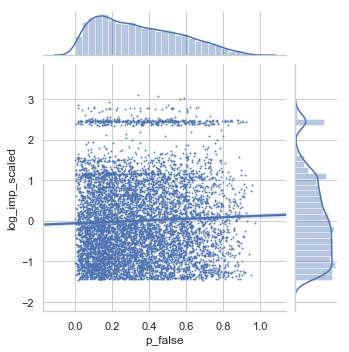

KendalltauResult(correlation=0.024563139234814367, pvalue=0.0015979375076716573)

In [13]:
sl_imp_corr('nytimes.com', 'foxnews.com', True)

In [9]:
domains = df.domain.unique()

In [10]:
pairs = list(combinations(domains, 2))

In [142]:
rows = []
for d1, d2 in tqdm(pairs):

    kt = sl_imp_corr(d1, d2)
    rows.append((d1, d2, kt.correlation, kt.pvalue))
    
    kt = sl_imp_corr(d2, d1)
    rows.append((d2, d1, kt.correlation, kt.pvalue))

120it [03:07,  1.61s/it]


In [150]:
corr_df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))
corr_df['label'] = corr_df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

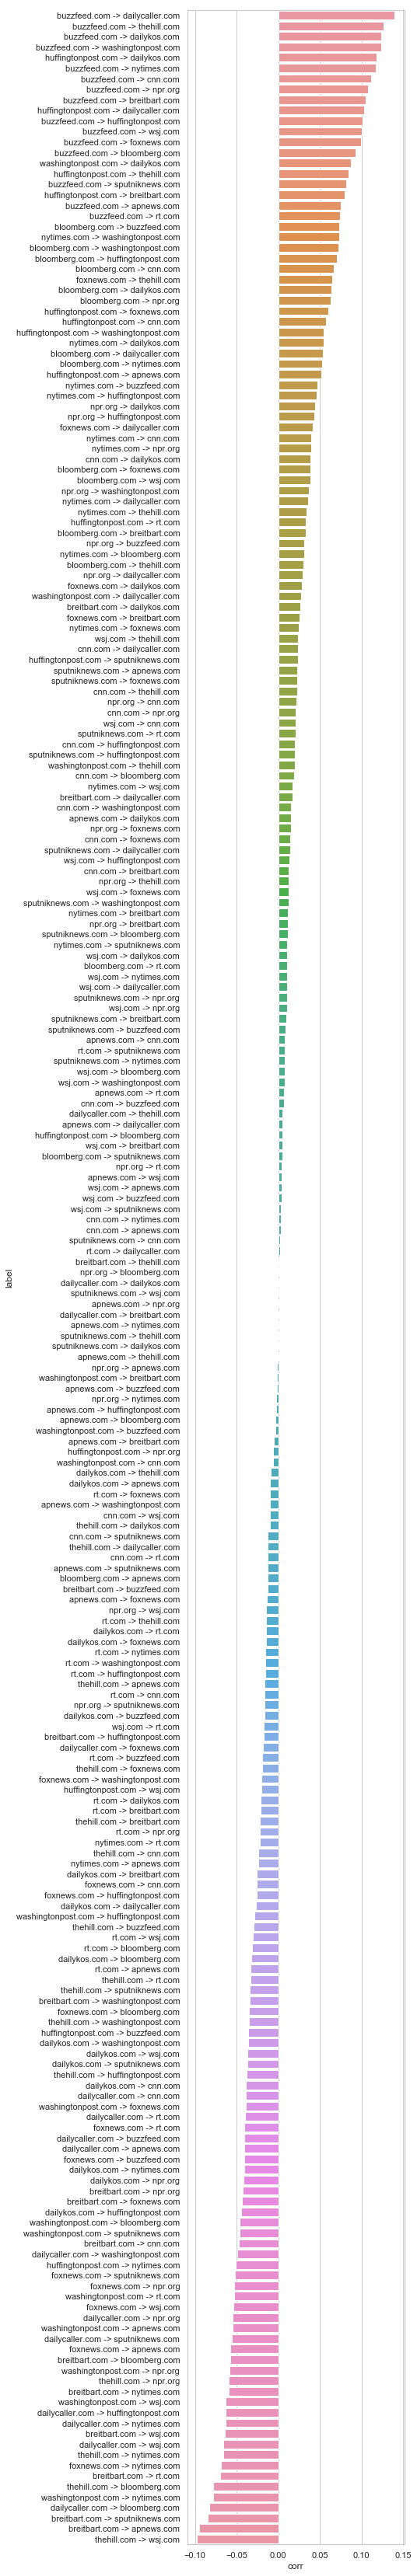

In [152]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=corr_df.sort_values('corr', ascending=False))

buzzfeed.com dailycaller.com


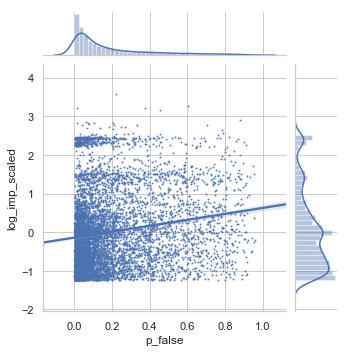

buzzfeed.com thehill.com


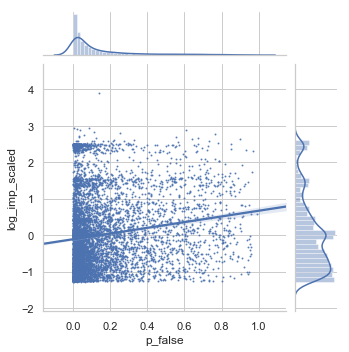

buzzfeed.com dailykos.com


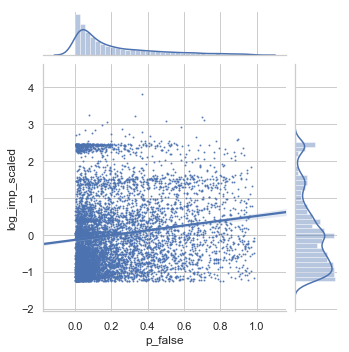

buzzfeed.com washingtonpost.com


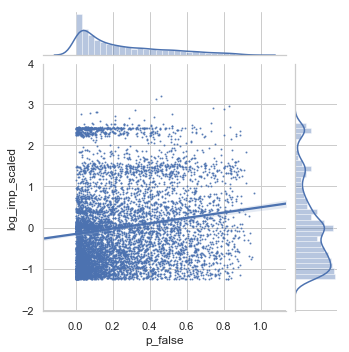

huffingtonpost.com dailykos.com


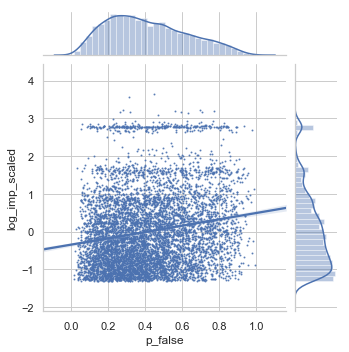

buzzfeed.com nytimes.com


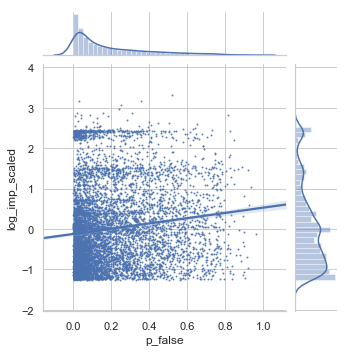

buzzfeed.com cnn.com


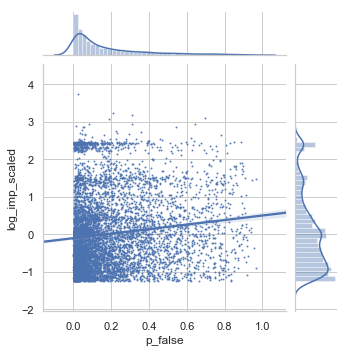

buzzfeed.com npr.org


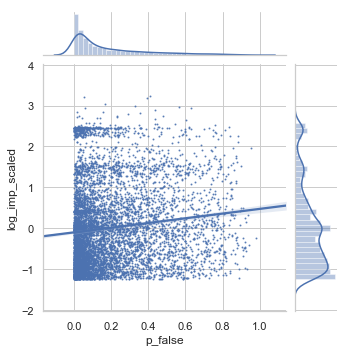

buzzfeed.com breitbart.com


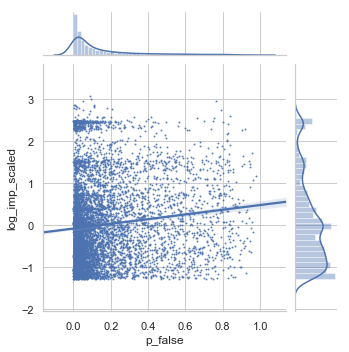

huffingtonpost.com dailycaller.com


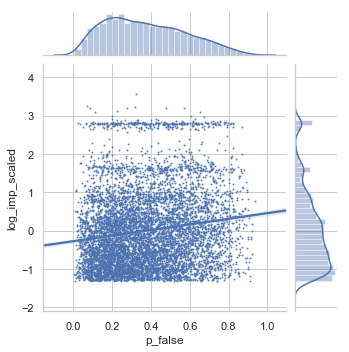

In [162]:
for r in corr_df.sort_values('corr', ascending=False).head(10).itertuples():
    print(r.d1, r.d2)
    sl_imp_corr(r.d1, r.d2, True)

thehill.com wsj.com


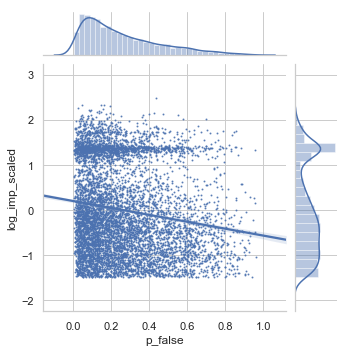

breitbart.com apnews.com


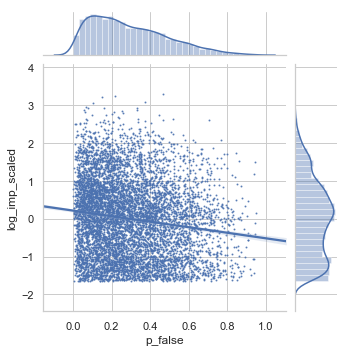

breitbart.com sputniknews.com


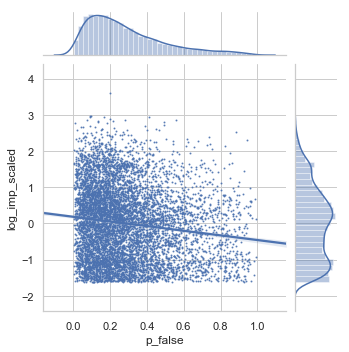

dailycaller.com bloomberg.com


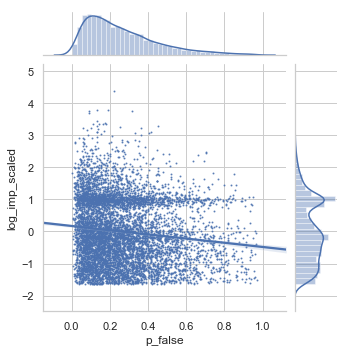

washingtonpost.com nytimes.com


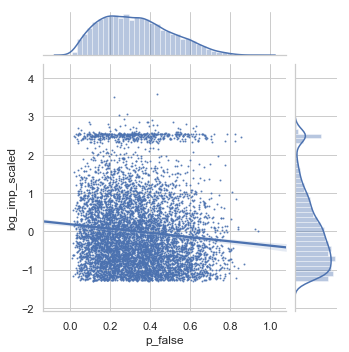

thehill.com bloomberg.com


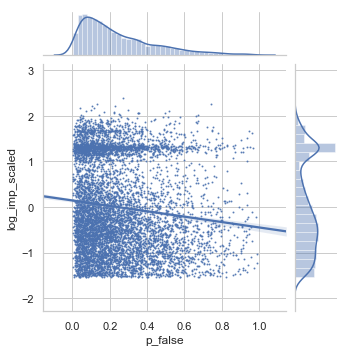

breitbart.com rt.com


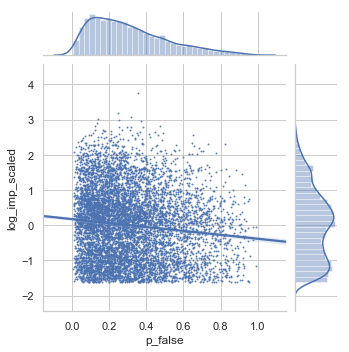

foxnews.com nytimes.com


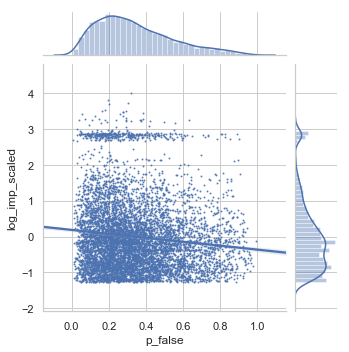

thehill.com nytimes.com


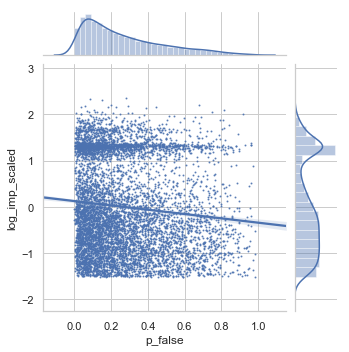

dailycaller.com wsj.com


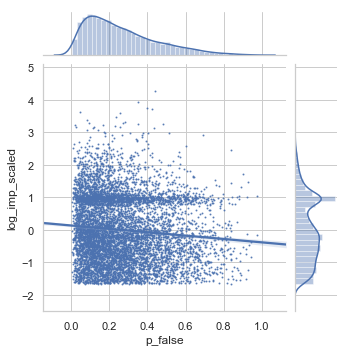

In [163]:
for r in corr_df.sort_values('corr', ascending=True).head(10).itertuples():
    print(r.d1, r.d2)
    sl_imp_corr(r.d1, r.d2, True)

In [167]:
corr_df.groupby('d2').mean().sort_values('corr', ascending=False)

,corr,p
d2,,
dailykos.com,0.038829,0.149592
dailycaller.com,0.030955,0.111416
thehill.com,0.026763,0.241906
breitbart.com,0.014643,0.228995
washingtonpost.com,0.013037,0.050666
cnn.com,0.008813,0.099480
foxnews.com,0.008670,0.039721
huffingtonpost.com,0.005257,0.059841
buzzfeed.com,-0.001947,0.194650


On average, moving towards DK correlates most with impressions.